### Mie First
Mie theory provides a route to the exact solution to Maxwell's equations for light interacting with a spherical object; this is done by expanding the incident and scattered
light waves in a basis of multi-polar functions; hence one usually speaks about the dipolar contribution to scattering, the quadrupolar contribution, the octupolar, and so on.  For very large particles, many orders of this expansion may be needed, but for small particles the scattering and absorption is dominated by the dipolar contribution.  Hence, for spherical nanoparticles that are less than or equal to about 10 nm in diameter, the Mie theory expansion is truncated after only the first term.  As a concrete example, the Mie theory expression for the absorption of a small spherical nanoparticle is as follows:

\begin{equation}
\sigma_{abs}(\lambda) = \frac{2 \pi}{\lambda} {\rm Im}\left( \alpha(\lambda) \right),
\end{equation}
where $\alpha(\lambda)$ is the dipole polarizability given by
\begin{equation}
\alpha(\lambda) = 4 \pi r^3 \left( \frac{\epsilon_p(\lambda) - \epsilon_s}{\epsilon_p(\lambda) + 2\epsilon_s} \right)
\end{equation}
where $r$ is the radius of the particle, $\epsilon_p(\lambda)$ denotes the wavelength-dependent dielectric function of the material the particle is made from, $\epsilon_s$ denotes the dielectric function of the surroundings (or solvent) that the particle is immersed in, and ${\rm Im}$ means we will only take the imaginary part of the quotient (the dielectric function of the particle will typically be complex; if it is not, there will be no absorption).

We can use WPTherml to get the refractive index of materials as a function of wavelength, which is equivalent to the dielectric function as a function of wavelength by
\begin{equation}
\epsilon_p(\lambda) = n_p(\lambda)^2,
\end{equation}
where $n_p(\lambda)$ is the refractive index of the particle. 


In [105]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from wptherml.datalib import datalib
import numpy as np
from numpy import linalg as LA
import math

 Temperature not specified!
 Proceeding with default T = 300 K


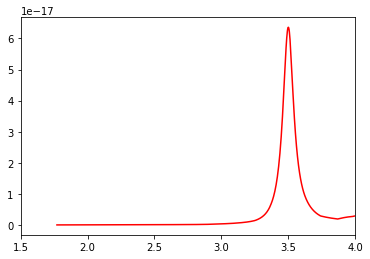

617
6.361971774588674e-17
3.543271635817909e-07


In [106]:
structure = {

        'Material_List': ['Air', 'Ag', 'Air'],
        'Thickness_List': [0,  200e-9, 0],
        'Lambda_List': [200e-9, 700e-9, 2000],
     
        }

### create the silver object - call it sphere for no particular reason
sphere = multilayer(structure)
### get the refractive index of Ag (since it is layer 1 based on the structure above)
n_Ag = sphere.layer_ri(1)
### get the dielectric function of Ag
eps_Ag = n_Ag * n_Ag

'''Lets compute the Mie theory absorption of a 3 nm Ag particle in water, which 
   has refractive index = 1.33, here!'''
r = 3e-9 ### fill in radius here, use meters!
eps_s =  1.00 ### fill in dielectric function of water here!
quotient = (eps_Ag - eps_s)/(eps_Ag + 2*eps_s) ### compute the quotient whose Imaginary part you need from Mie theory expression here
alpha = 4*np.pi*r**3 * quotient
pre = 2*np.pi/sphere.lambda_array ### compute pre-factor that depends on wavelength and radius here!
sigma_abs = pre*np.imag(alpha) ### compute full absorption spectrum here!

plt.plot(1240/(sphere.lambda_array*1e9), sigma_abs, 'red')
plt.xlim(1.5, 4)
plt.show()

lidx = np.argmax(sigma_abs)
print(lidx)
print(sigma_abs[lidx])
print(sphere.lambda_array[lidx])

A slightly more sophisticated update scheme is given by the family of methods known as 
[Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), and a particular implementation of this method can be found below in the function called *RK4*.



We will compare the results of the two methods (RK4 and Euler) in 
reproducing the Mie theory spectrum for a 3 nm Ag atom.  
The following Hamiltonian parameters will be used, and should in principle provide good agreement provided the equations of motion are accurately solved:
In atomic units, $E_2 = 0.1275, \mu_{12} = 58.$, and $\gamma=0.0017$ gives excellent agreement with the Mie theory spectrum, as we will see below.

In [107]:
import math

def Euler (H0, mu, Vint, gamma, D, h, t, tau):  
    ###Defined Hamiltonian at the current time    
    H = H0- EField(t, tau) * mu 
    ### Define the time derivarive of our density matrix at the current time
    ### by evaluating the Liouville-Lindblad equation
    Ddot = Liouville(H,D) + Lindblad(D, gamma)
    ###
    Dnew = D + h*Ddot
    return Dnew

def Lindblad(D, gamma):
    dim = len(D)
    LD = np.zeros_like(D)
    ### need |g><g|
    bra_1 = CreateBas(dim, 0)
    gm = Form_Rho(bra_1)
    
    for k in range(1,dim):
        bra_k = CreateBas(dim, k)
        km = Form_Rho(bra_k)
        
        ### first term 2*gam*<k|D|k>|g><g|
        t1 = 2*gamma*D[k][k]*gm
        ### second term is |k><k|*D
        t2 = np.dot(km,D)
        ### third term is  D*|k><k|
        t3 = np.dot(D, km)
        LDA = LD + t1 - gamma*t2 - gamma*t3
        
    return LD
       
### Take commutator of H and D to give Ddot
def Liouville(H, D):
    ci = 0.+1j
    return -ci*(np.dot(H,D) - np.dot(D, H))

def EField(t, tau):
    Ef = 0
    if t<tau:
        Ef = 0.001*np.sin(t*np.pi/tau)*np.sin(t*np.pi/tau)*np.sin(0.1192*t)
    return Ef

def Form_Rho(Psi):

    D = np.outer(Psi,np.conj(Psi))
    return D

### Creates basis vector for state k
### k=0 -> ground state, k=1 -> first excited-state, etc
def CreateBas(dim, k):
    bas = np.zeros(dim)
    bas[k] = 1
    return bas


### Vint will take three vectors: 
### R the separation vector, 
### MUA is the vector representing the
### transition dipole moment on one of your particles (does not
### change with time) and MUB is the vector
### representing the instantaneous dipole moment on the other particle
### (it does change with time)
def Vint(R, MUA, MUB):
    n = 1
    normr = math.sqrt(np.dot(R,R))
    oer2 = 1./(normr**2)
    pre = 1./(n**2 * normr**3)
    
    t1 = np.dot(MUA,MUB)
    t2 = np.dot(MUA,R)
    t3 = np.dot(R,MUB)
    
    Vint_val = pre*(t1 - 3*oer2*t2*t3)
    
    return Vint_val

In [108]:
def RK4(H0, mu, Vint, gamma, D, h, t, tau):
    k1 = np.zeros_like(D)
    k2 = np.zeros_like(D)
    k3 = np.zeros_like(D)
    k4 = np.zeros_like(D)
    D1 = np.zeros_like(D)
    D2 = np.zeros_like(D)
    D3 = np.zeros_like(D)
    D4 = np.zeros_like(D)
    Df = np.zeros_like(D)
    
    ### Get k1
    H1 = H0 - EField(t, tau)*mu + Vint
    D1 = D    
    k1 = h*Liouville(H1,D1) + h*Lindblad(D1, gamma)
    
    ## Update H and D and get k2
    H2 = H0 - EField(t+h/2, tau)*mu 
    D2 = D+k1/2.
    k2 = h*Liouville(H2, D2) + h*Lindblad(H2, gamma)
    
    ### UPdate H and D and get k3
    H3 = H2
    D3 = D+k2/2
    k3 = h*Liouville(H3, D3) + h*Lindblad(D3, gamma) 
    
    ### Update H and D and get K4
    H4 = H0 - EField(t+h, tau)*mu + Vint
    D4 = D+k3
    k4 = h*Liouville(H4, D4) + h*Lindblad(D4, gamma)
    
    Df = D + (1/6.)*(k1 + 2.*k2 + 2*k3 + k4)
    return Df

In [109]:
import numpy as np

In [110]:
### Set up some parameters for the quantum dynamics simulation
dt = 0.05
tau = 100 #150.
gammaA = 0.0017
gammaB = 0.0017
eps0 = 8.854e-12
muA = 8.854e-12
muB = 8.854e-12
#mu_au_to_si = 8.47835326e-30
#E_au_to_si = 5.14220652e11
mu_zA = 58.
mu_zB = 58.
R = 30
### Create some arrays
MUZA = np.zeros((2,2),dtype=complex)
VintA = np.zeros((2,2),dtype=complex)
### Density matrix for RK4 updates
DA_RK4 = np.zeros((2,2),dtype=complex)
### Density matrix for Euler updates
DA_EU = np.zeros((2,2),dtype=complex)
HA0 = np.zeros((2,2))
### Create some arrays
MUZB= np.zeros((2,2),dtype=complex)
VintB = np.zeros((2,2),dtype=complex)
### Density matrix for RK4 updates
DB_RK4 = np.zeros((2,2),dtype=complex)
### Density matrix for Euler updates
DB_EU = np.zeros((2,2),dtype=complex)
HB0 = np.zeros((2,2))

### initialize values of the arrays for Hamiltonian and Density matrices
HA0[0][0] = 0.1275
DA_RK4[0][0] = 1.+0j
DA_EU[0][0] = 1.+0j
MUZA[0][1] = mu_zA
MUZA[1][0] = mu_zA
### initialize values of the arrays for Hamiltonian and Density matrices
HB0[0][0] = 0.1275
DB_RK4[0][0] = 1.+0j
DB_EU[0][0] = 1.+0j
MUZB[0][1] = mu_zB
MUZB[1][0] = mu_zB


### need vectors to pass to the function Vint...
### these vectors will store information about R, MUZA, MUZB (all static)
### and we will also create additional vectors that store the time-dependent 
### quantities
### arrays for static quantities first
### there are 3 components for the x-, y-, and z- components
### of these vector quantities
MUA_VEC = np.zeros(3)
MUB_VEC = np.zeros(3)
R_VEC = np.zeros(3)
### actually assign the values of the static quantities...
### note only the z-component (index 2) is non-zero for now!
MUA_VEC[2] = mu_zA
MUB_VEC[2] = mu_zB
R_VEC[2] = R

### time-dependent quantities - still x-, y-, and z- components
### in principle, though only the z-component (index 2) will be non-zero
MUA_OF_T = np.zeros(3)
MUB_OF_T = np.zeros(3)

### create arrays for time-dependent quantities
Nsteps = 40000
ez = np.zeros(Nsteps)

### array for mu(t) for RK4 updates
MUA_of_t_RK4 = np.zeros(Nsteps,dtype=complex)
MUB_of_t_RK4 = np.zeros(Nsteps,dtype=complex)
### array for mu(t) for Euler updates
MUA_of_t_EU = np.zeros(Nsteps,dtype=complex)
MUB_of_t_EU = np.zeros(Nsteps,dtype=complex)
time = np.zeros(Nsteps)
energy = np.zeros(Nsteps)
g = np.zeros(Nsteps,dtype=complex)

### Run the dynamics for both systems simultaneously
for i in range(0,Nsteps):
    ### reciprocal axis
    energy[i] = np.pi*2*(i+1)/(Nsteps*dt)
    ### time access
    time[i] = i*dt
    ### time-dependent electric field
    ez[i] = EField(i*dt, tau)
    ### update to the Density matrix using RK4
    DA_RK4 = RK4(HA0, MUZA, VintA, gammaA, DA_RK4, dt, dt*i, tau)
    DA_EULER = Euler(HA0, MUZA, VintA, gammaA, DA_RK4, dt, dt*i, tau)
    ### use np.matmul to take the matrix product of DA_RK4 and MUZA
    DMA = np.matmul(DA_RK4, MUZA)
    ### DMA is now the matrix product of DA_RK4 and MUZA
    ### TO GET THE TRACE, WE JUST SUM THE DIAGONAL ELEMENTS...
    ### AND WE WANT TO STORE THE TRACE DIRECTLY IN OUR MUA_OF_T 
    ### ARRAY FOR USE IN THE Vint FUNCTION
    MUA_OF_T[2] = DMA[0][0]+DMA[1][1]
    MUA_of_t_RK4[i] =MUA_OF_T[2] 
    MUA_of_t_EU[i] =MUA_OF_T[2] 
    ### Vint function currently returns a scalar value..
    ### these scalar values are the off-diagonal elements of the VintB/VintA 
    ### matrices we will pass to RK4
    g[i] = Vint(R_VEC, MUB_VEC, MUA_OF_T)
    VintB[0][1] = Vint(R_VEC, MUB_VEC, MUA_OF_T)
    VintB[1][0] = Vint(R_VEC, MUB_VEC, MUA_OF_T)

    #### NOW CALL TRY TO REPEAT THE PROCESS TO UPDATE DB_RK4 HERE!
    DB_RK4 = RK4(HB0, MUZB, VintB, gammaB, DB_RK4, dt, dt*i, tau)
    DB_EULER = Euler(HB0, MUZB, VintB, gammaB, DB_RK4, dt, dt*i, tau)
    DMB = np.matmul(DB_RK4, MUZB)
    MUB_OF_T[2] = DMB[0][0]+DMB[1][1]
    MUB_of_t_RK4[i] = MUB_OF_T[2]
    MUB_of_t_EU[i] =MUB_OF_T[2] 
    VintA[0][1] = Vint(R_VEC, MUA_VEC, MUB_OF_T)
    VintA[1][0] = Vint(R_VEC, MUA_VEC, MUB_OF_T)
    

print(energy[0])


C:\Users\12014\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\12014\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: ComplexWarning: Casting complex values to real discards the imaginary part


0.0031415926535897933


In [111]:
type(MUA_of_t_RK4)
len(MUA_of_t_RK4)

40000

In [112]:
type(MUB_of_t_RK4)
len(MUB_of_t_RK4)

40000

In [113]:
type(time)
len(time)

40000

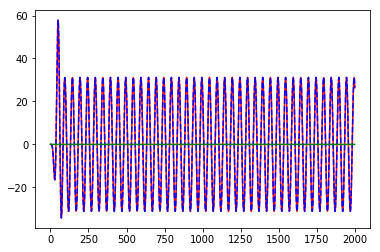

In [102]:
### Run the dynamics 1
plt.plot(time, MUA_of_t_RK4, 'red', time, MUB_of_t_RK4, 'b--', time, ez, 'green')
#plt.xlim(0,200)
plt.show()

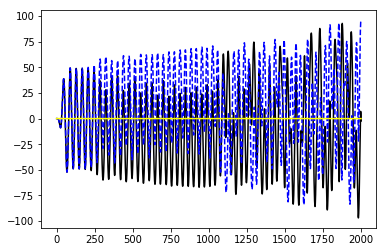

In [114]:
### Run the dynamics 2
plt.plot(time, MUA_of_t_EU, 'black', time, MUB_of_t_EU, 'b--', time, ez, 'yellow')
#plt.xlim(0,200)
plt.show()

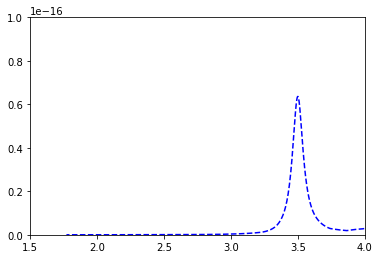

<function matplotlib.pyplot.show(*args, **kw)>

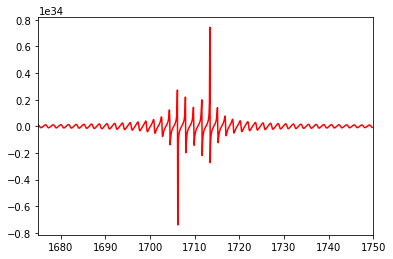

In [115]:

MUA_freq_rk4 = np.fft.fft(MUA_of_t_RK4)/(Nsteps)
ez_freq = np.fft.fft(ez)/(Nsteps)
alphaA_rk4 = MUA_freq_rk4/ez_freq
lam = 1e-9*1240/(energy*27.211) ### in nm

sigma_rk4_A = 2*np.pi/(lam*eps0) * np.imag(alphaA_rk4)

plt.plot(1240/(sphere.lambda_array*1e9), sigma_abs, 'b--')
plt.xlim(1.5,4)
plt.ylim(0,1e-16)
plt.show()

plt.plot(energy*27.211, sigma_rk4_A, 'red')
plt.xlim(1675, 1750)
plt.show
